In [2]:
%pip install -q swifter torchvision opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:

DATASET_PATH = "F:\\final\\Data\\"

print(os.listdir(DATASET_PATH))


['images', 'styles.csv']


In [5]:
import pandas as pd

with open(DATASET_PATH + 'styles.csv', 'r', errors='ignore') as f:
    df = pd.read_csv(f)

print(df.head(10))


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName Unnamed: 10  \
0  2011.0  Casual               Turtle Check Men Navy Blue Sh

In [6]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: total: 93.8 ms
Wall time: 99.4 ms


In [7]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN,53759.jpg


In [8]:
import cv2


IMAGE_PATH = "F:\\final\\Data\\images\\"

def plot_figures(figures, nrows=1, ncols=1, figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()  

def image_location(img):
    return IMAGE_PATH + img


def import_img(image):
    image = cv2.imread(image_location(image))
    return image

    

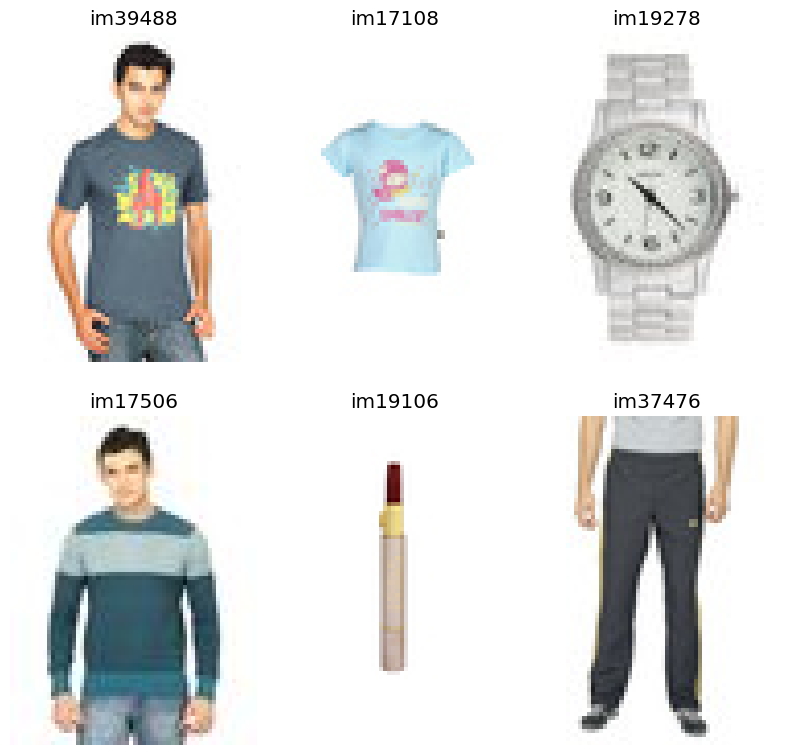

In [9]:
figures = {'im'+str(i): cv2.imread(IMAGE_PATH + row.image) for i, row in df.sample(6).iterrows()}

plot_figures(figures, 2, 3)


<Axes: ylabel='articleType'>

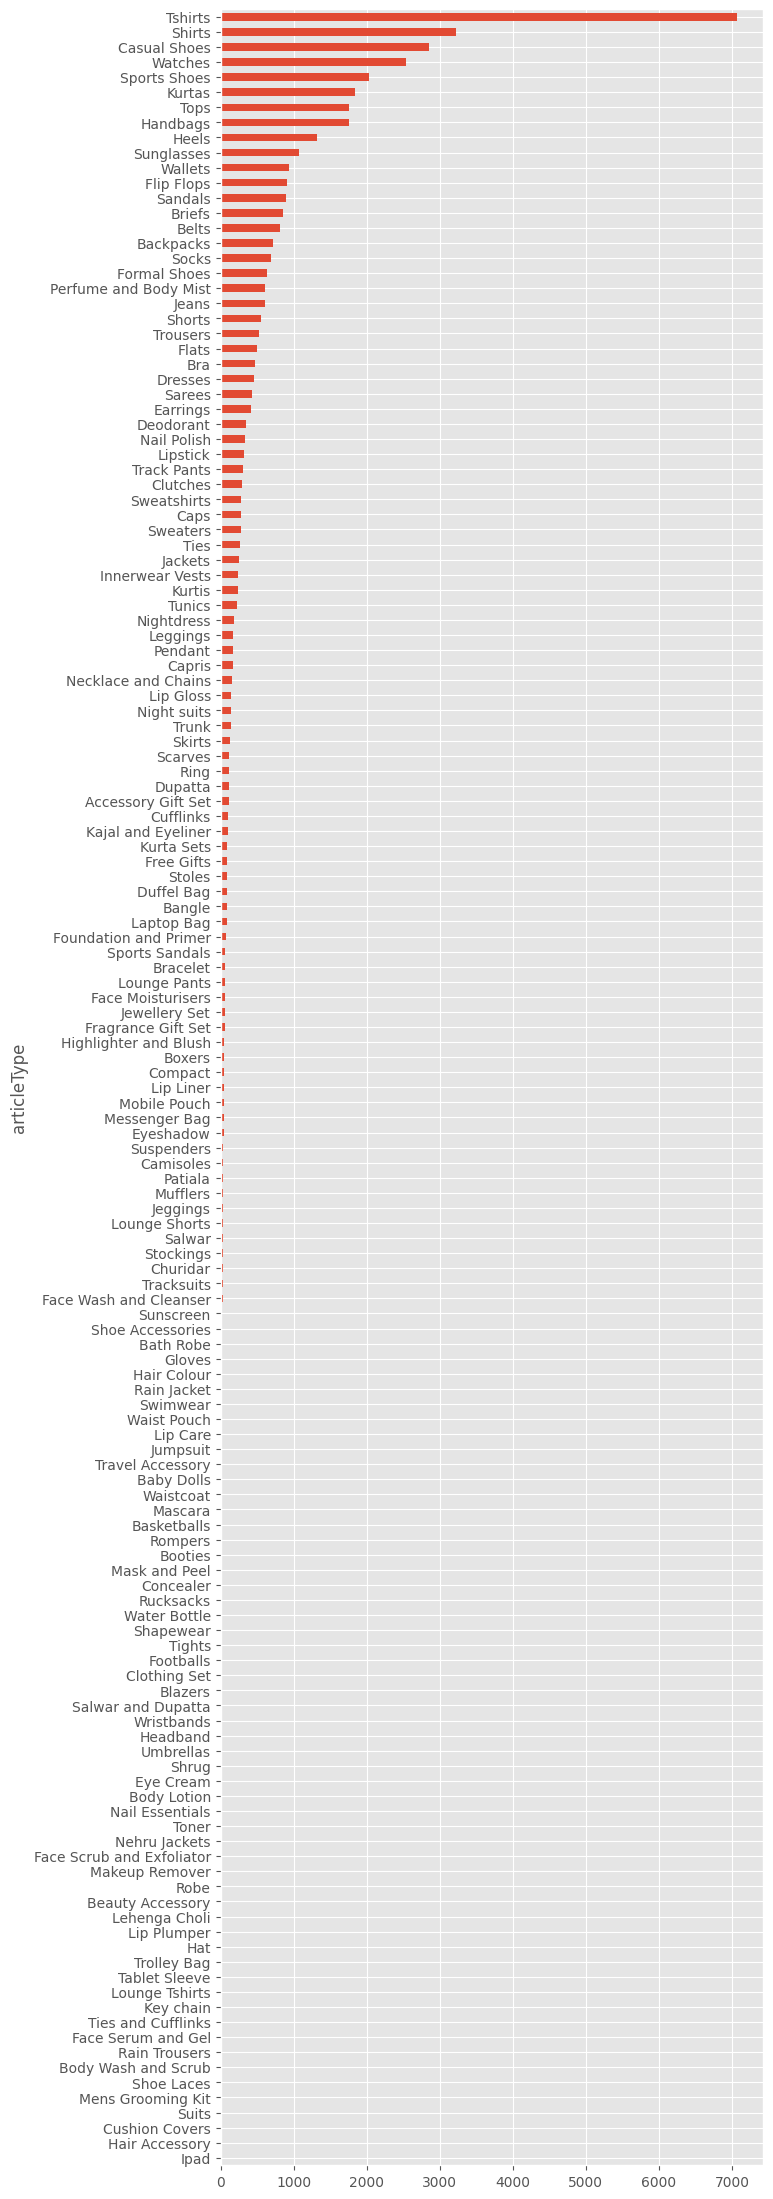

In [10]:
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [11]:
width= 224
height= 224
#loading ResNet18 Model
resnetmodel = models.resnet18(pretrained=True)

layer = resnetmodel._modules.get('avgpool')

In [12]:
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#scaling, normalize and convert to tensor 
s_data = transforms.Resize((224, 224))

standardize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

convert_tensor = transforms.ToTensor()

In [14]:
from PIL import Image
#vector extraction
missing_img = []
def vector_extraction(resnetmodel, image_id):
   
    try: 
        img = Image.open(IMAGE_PATH + image_id).convert('RGB')
        
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        
        embeddings = torch.zeros(512)
        
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
            
        hlayer = layer.register_forward_hook(copy_data)
        
        resnetmodel(t_img)
        
        hlayer.remove()
        emb = embeddings
        
        return embeddings
    
    except FileNotFoundError:
        missed_img = df[df['image'] == image_id].index
        print(missed_img)
        missing_img.append(missed_img)


In [15]:
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

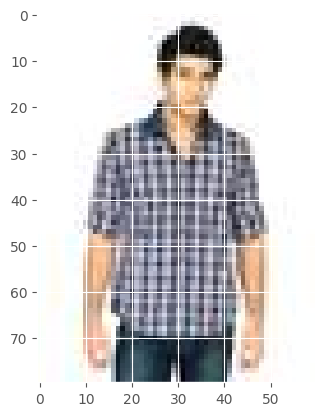

In [16]:
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

In [17]:
df.shape

(44446, 13)

In [19]:
import swifter
import pandas as pd

# Function for vector extraction
def safe_vector_extraction(model, img):
    try:
        return vector_extraction(model, img).detach().numpy().tolist()
    except Exception as e:
        print(f"Error processing image: {e}")
        return [None] * 512  

# sample dataset
df_embeddings = df[:5000]

map_embeddings = df_embeddings['image'].swifter.apply(lambda img: safe_vector_extraction(resnetmodel, img))

feature_names = [f"feature_{i+1}" for i in range(512)]

df_embs = pd.DataFrame(map_embeddings.tolist(), columns=feature_names)

print(df_embs.shape)
print(df_embs.head())


Pandas Apply: 100%|██████████| 5000/5000 [07:54<00:00, 10.54it/s]


(5000, 512)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.018092   1.042106   0.030759   0.106612   0.248215   1.314161   
1   0.034120   0.804466   0.071094   0.286108   0.118644   0.485673   
2   0.306780   0.196792   2.325820   0.337870   0.206403   0.410262   
3   0.052566   0.312827   0.318464   0.045759   0.207993   0.486138   
4   0.146032   0.624985   0.023858   0.201499   0.273301   2.073839   

   feature_7  feature_8  feature_9  feature_10  ...  feature_503  feature_504  \
0   0.070166   0.269750   1.374099    0.434486  ...     0.663422     0.474600   
1   0.767112   0.116924   1.131223    1.229430  ...     0.125502     0.554489   
2   2.865740   0.493548   2.894565    3.824198  ...     0.377006     3.216579   
3   0.871357   0.437959   0.861974    1.257671  ...     0.000401     0.126219   
4   0.038832   0.537267   1.338016    0.428539  ...     0.039452     1.069758   

   feature_505  feature_506  feature_507  feature_508  feature_509  \
0   

In [22]:
df_embs.to_csv('F:\\final\\Data\\df_embs.csv')
df_embs = pd.read_csv('F:\\final\\Data\\df_embs.csv')
df_embs.drop(['Unnamed: 0'], axis=1, inplace=True)
df_embs.dropna(inplace=True)

In [21]:
import joblib

joblib.dump(df_embs, 'F:\\final\\Data\\df_embs.pkl', compress=9)

df_embs = joblib.load('F:\\final\\Data\\df_embs.pkl')


In [23]:
#calculating cosine similarities
cosine_sim = cosine_similarity(df_embs) 
cosine_sim[:4, :4]

array([[1.        , 0.76400117, 0.54799322, 0.77531747],
       [0.76400117, 1.        , 0.4961708 , 0.8849266 ],
       [0.54799322, 0.4961708 , 1.        , 0.52310662],
       [0.77531747, 0.8849266 , 0.52310662, 1.        ]])

In [24]:
index_values = pd.Series(range(len(df)), index=df.index)

def recommend_images(ImId, df, top_n=6):
    
    sim_ImId = index_values[ImId]
    
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:top_n+1]
    
    ImId_rec = [i[0] for i in sim_scores]
    
    ImId_sim = [i[1] for i in sim_scores]
    
    return index_values.iloc[ImId_rec].index, ImId_sim

recommend_images(3810, df, top_n=5)


(Index([2400, 3678, 3899, 2354, 1247], dtype='int64'),
 [0.9609788138420821,
  0.95858126914439,
  0.9572631183932551,
  0.9567468195707909,
  0.9551633379574626])

In [25]:
def Rec_viz_image(input_imageid): 

    idx_rec, idx_sim = recommend_images(input_imageid, df, top_n=6)
    
    print(idx_sim)
    
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    plot_figures(figures, 2, 3)


[0.9609788138420821, 0.95858126914439, 0.9572631183932551, 0.9567468195707909, 0.9551633379574626, 0.9547181358065702]


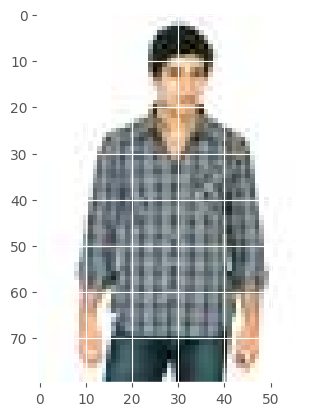

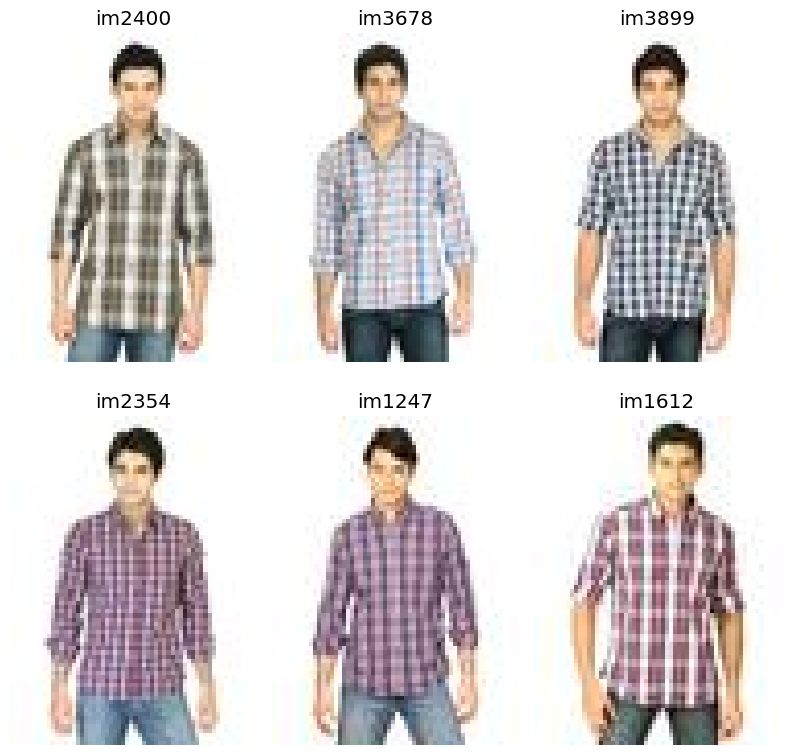

In [26]:
Rec_viz_image(3810)

[0.9726985504510337, 0.9467401798211644, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]


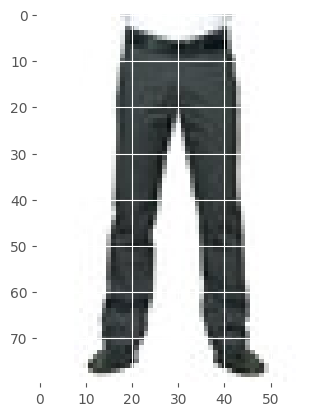

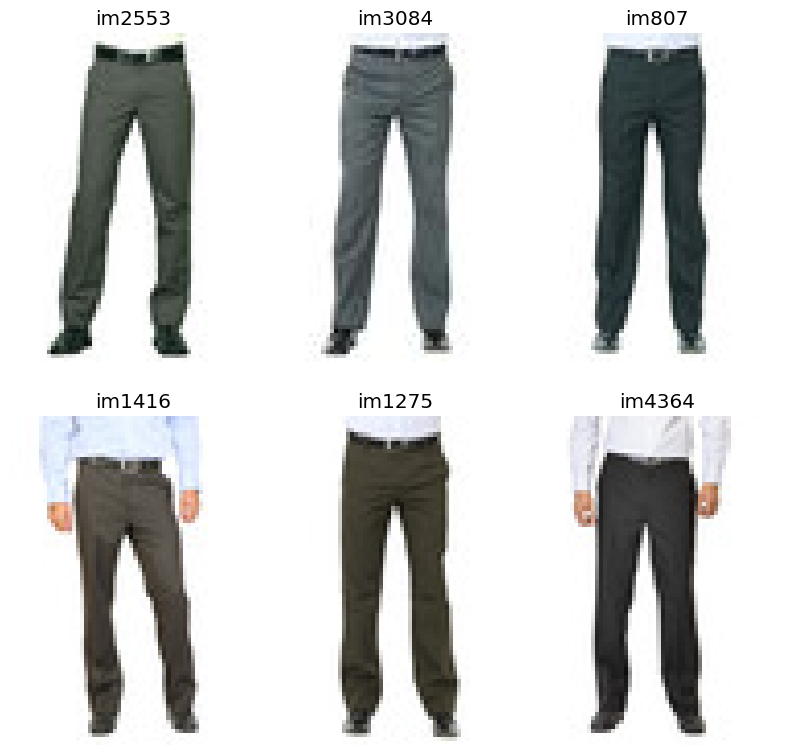

In [27]:
Rec_viz_image(2001)

In [27]:
def recm_user_input(image_id):
    
    img = Image.open('F:/final/Data/images/' + image_id).convert('RGB')
        
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
       
    embeddings = torch.zeros(512)
    def select_d(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
    hlayer = layer.register_forward_hook(select_d)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings
    
    cs = cosine_similarity(emb.unsqueeze(0), df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list, columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'], ascending=False)
        
    print(cs_df['Score'][:10])
    
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index == i]['image']
        print(image_id)
        images_list.append(image_id)
    images_list = list(flatten(images_list))
    print(images_list)
    
    figures = {'im' + str(i): Image.open('F:/final/Data/images/' + i) for i in images_list}
    fig, axes = plt.subplots(2, 5, figsize=(8, 8))
    for index, name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()


2674    0.878520
4316    0.875084
1357    0.870877
1452    0.869093
2437    0.868270
2059    0.860040
2267    0.859887
835     0.853278
4291    0.852133
4245    0.850108
Name: Score, dtype: float64
2674    4319.jpg
Name: image, dtype: object
4316    4327.jpg
Name: image, dtype: object
1357    25516.jpg
Name: image, dtype: object
1452    4310.jpg
Name: image, dtype: object
2437    4326.jpg
Name: image, dtype: object
2059    4328.jpg
Name: image, dtype: object
2267    4321.jpg
Name: image, dtype: object
835    5433.jpg
Name: image, dtype: object
4291    3330.jpg
Name: image, dtype: object
4245    7556.jpg
Name: image, dtype: object
['4319.jpg', '4327.jpg', '25516.jpg', '4310.jpg', '4326.jpg', '4328.jpg', '4321.jpg', '5433.jpg', '3330.jpg', '7556.jpg']


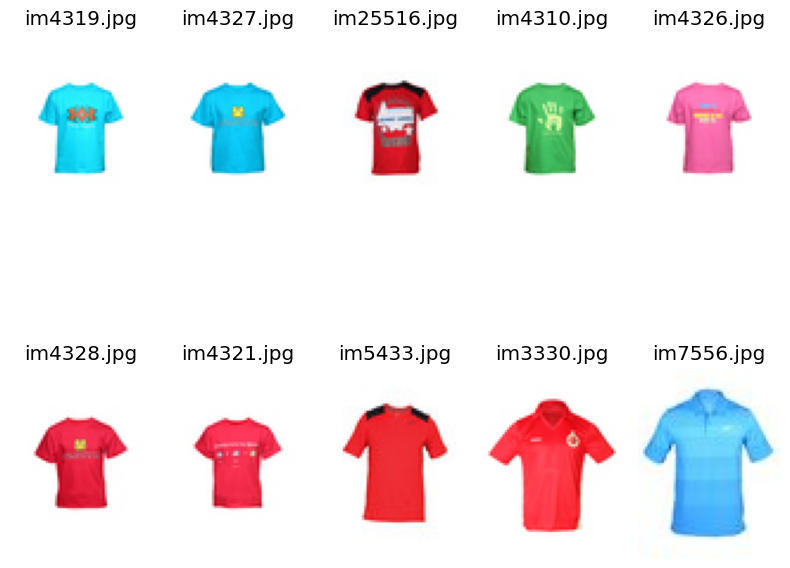

In [29]:
recm_user_input('1163.jpg')

[0.9202202201508662, 0.9176895434782674, 0.9170358541643923, 0.9087185792491033, 0.906287910157402, 0.9020148971983792]


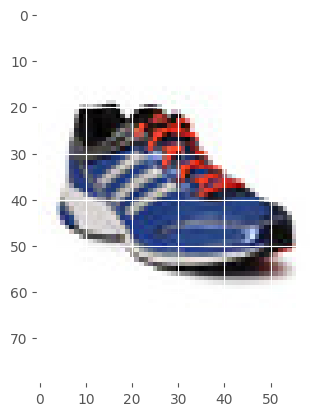

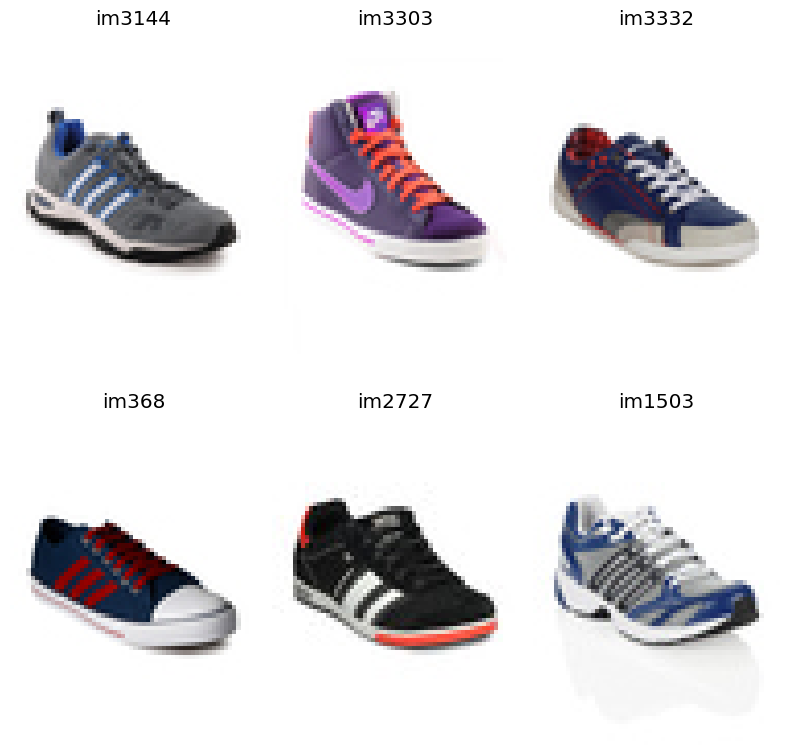

In [30]:
Rec_viz_image(1005)

[0.9450994264887427, 0.9431201885786531, 0.9400545022379712, 0.9346222037080203, 0.9340654931824199, 0.9287955775353653]


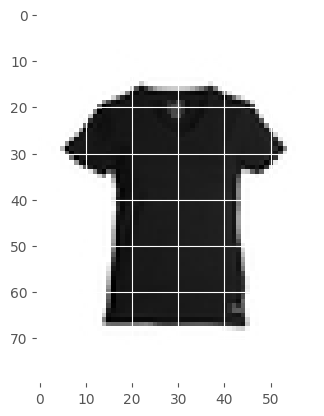

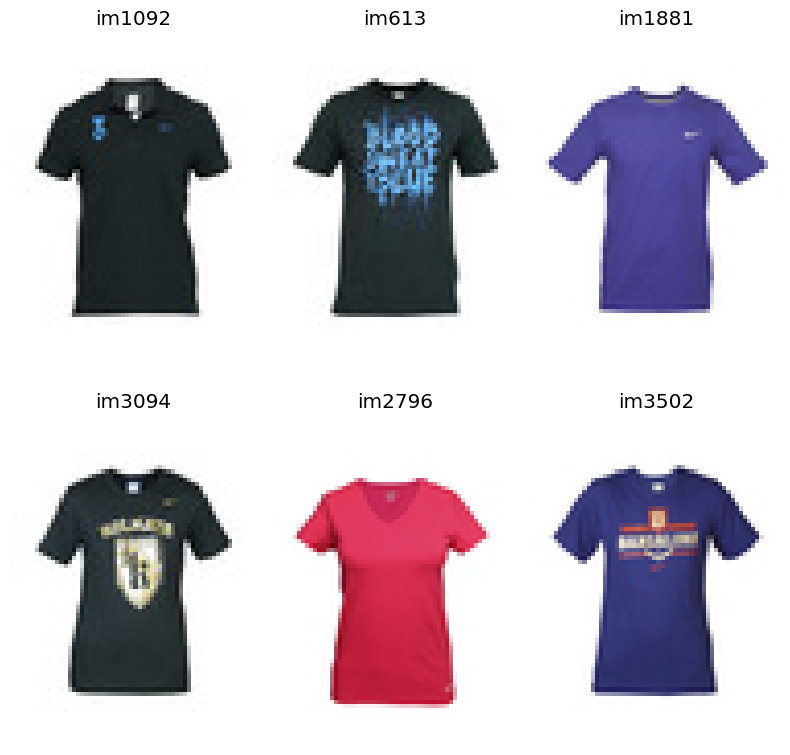

In [31]:
Rec_viz_image(1165)

[0.9437440402332754, 0.9332969869959742, 0.9253229215714276, 0.9206422767283048, 0.9143679451871038, 0.8362684996122964]


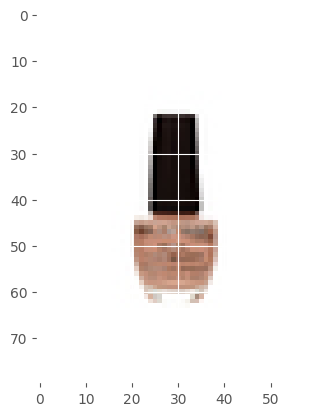

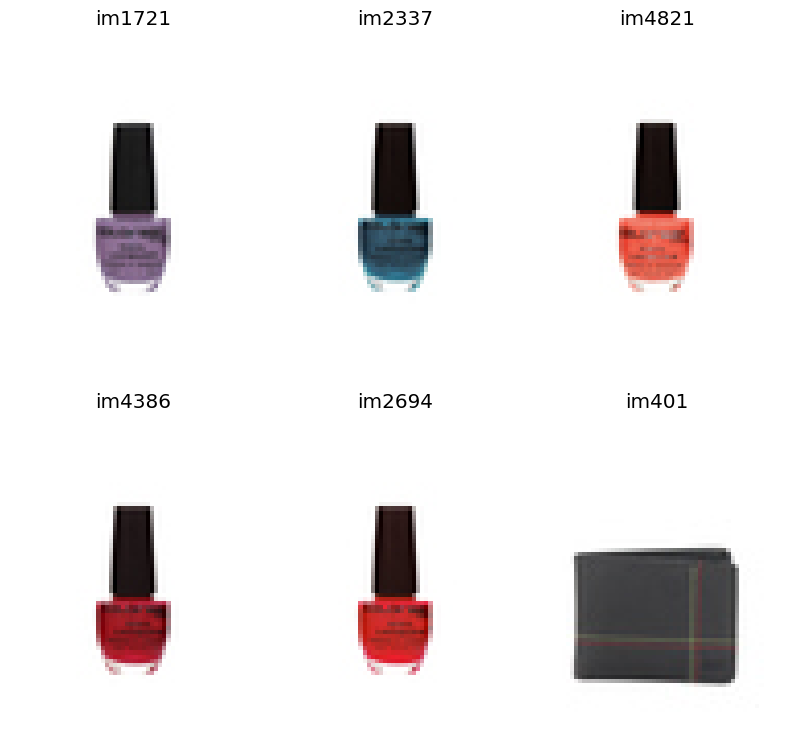

In [32]:
Rec_viz_image(1805)

[0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648]


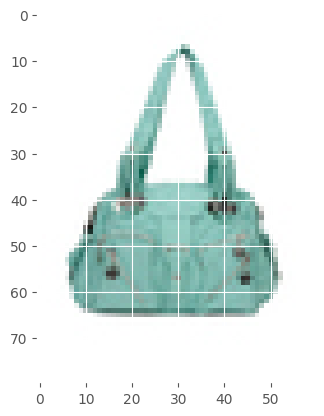

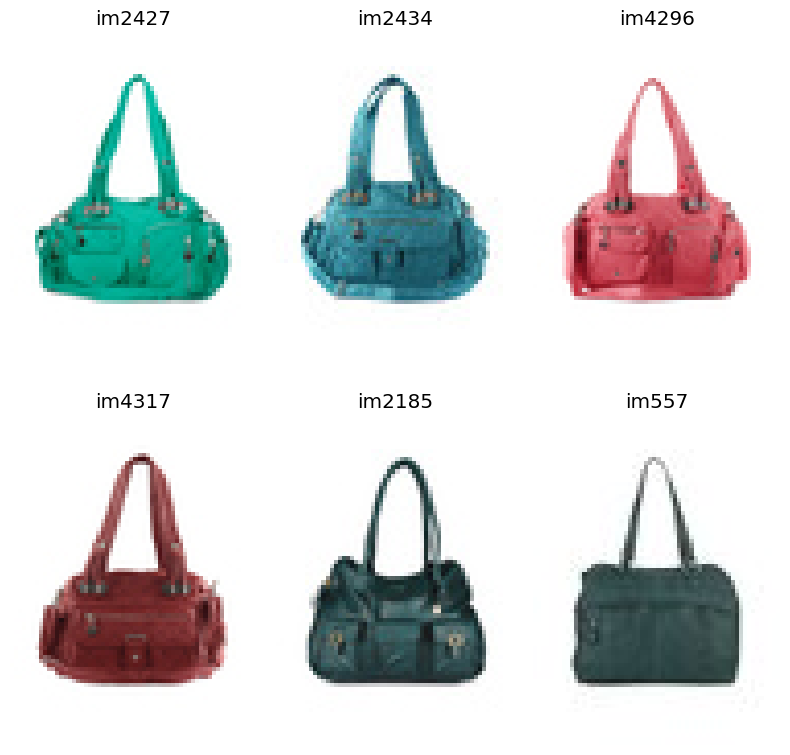

In [33]:
Rec_viz_image(2057)

[0.9467471695606031, 0.9378982344417668, 0.937346355112619, 0.9314500643526137, 0.9291788963644623, 0.9290125331281847]


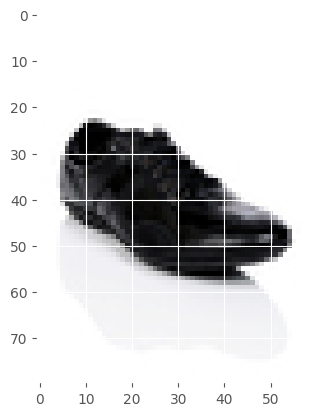

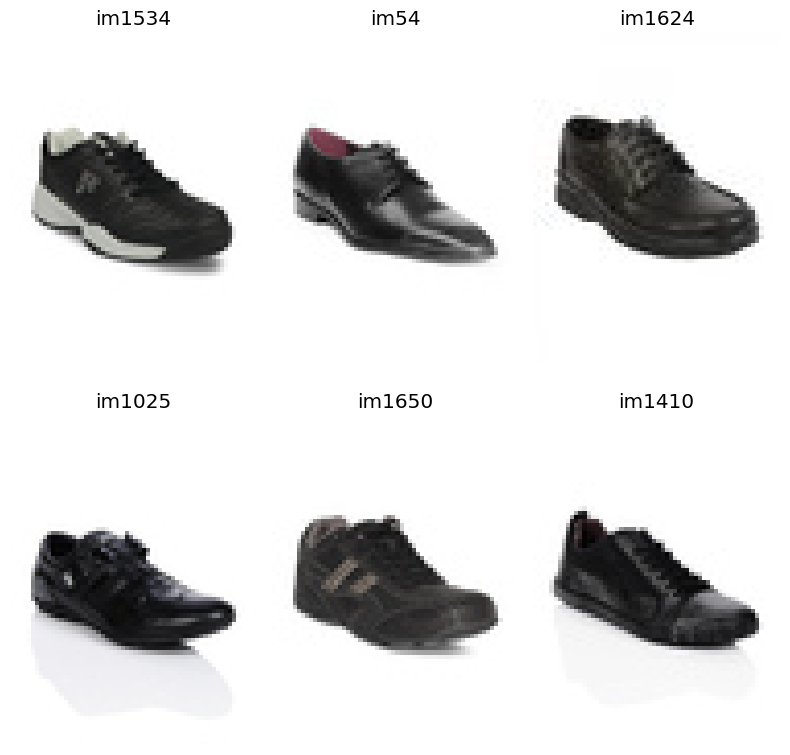

In [34]:
Rec_viz_image(3059)

Accuracy for input image 1: 89.85%
Accuracy for input image 2: 89.85%
Accuracy for input image 3: 91.23%
Accuracy for input image 4: 93.76%
Accuracy for input image 5: 94.68%
Total accuracy: 91.88%


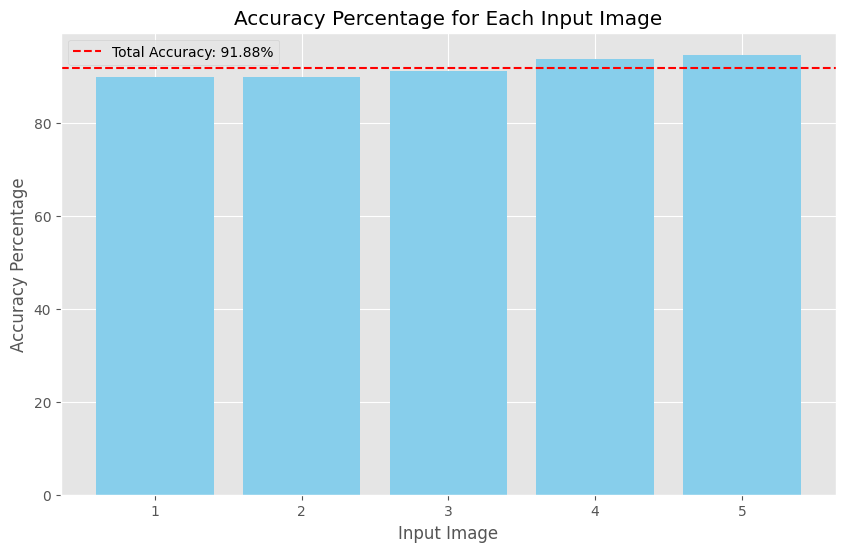

In [35]:
import matplotlib.pyplot as plt

similarity_scores = [
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9437440402332754, 0.9332969869959742, 0.9253229215714276, 0.9206422767283048, 0.9143679451871038, 0.8362684996122964],
    [0.9450994264887427, 0.9431201885786531, 0.9400545022379712, 0.9346222037080203, 0.9340654931824199, 0.9287955775353653],
    [0.9726985504510337, 0.9467401798211644, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]
]

accuracy_percentages = [(sum(scores) / len(scores)) * 100 for scores in similarity_scores]

total_accuracy_percentage = sum(accuracy_percentages) / len(accuracy_percentages)

for i, acc in enumerate(accuracy_percentages, 1):
    print(f"Accuracy for input image {i}: {acc:.2f}%")

print(f"Total accuracy: {total_accuracy_percentage:.2f}%")

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracy_percentages) + 1), accuracy_percentages, color='skyblue')
plt.xlabel('Input Image')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage for Each Input Image')
plt.xticks(range(1, len(accuracy_percentages) + 1))
plt.axhline(y=total_accuracy_percentage, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy_percentage:.2f}%')
plt.legend()
plt.grid(True)
plt.show()


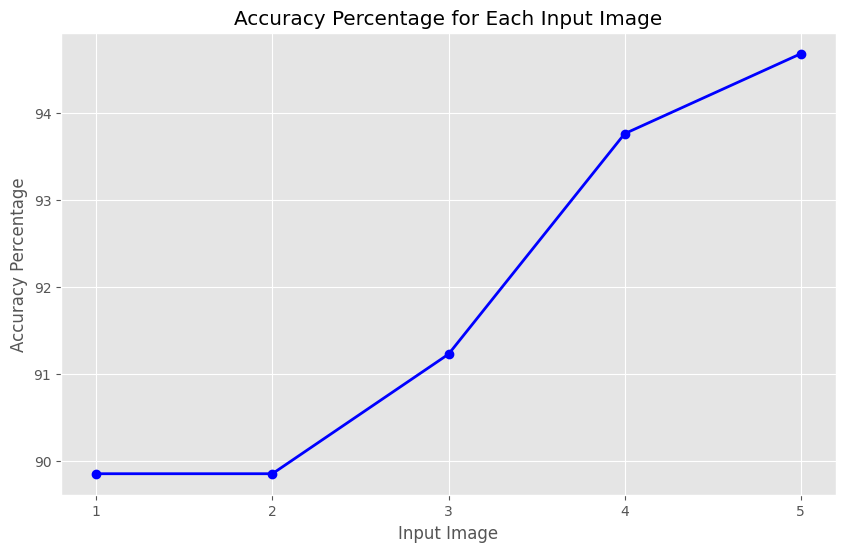

In [36]:
import matplotlib.pyplot as plt

similarity_scores = [
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9437440402332754, 0.9332969869959742, 0.9253229215714276, 0.9206422767283048, 0.9143679451871038, 0.8362684996122964],
    [0.9450994264887427, 0.9431201885786531, 0.9400545022379712, 0.9346222037080203, 0.9340654931824199, 0.9287955775353653],
    [0.9726985504510337, 0.9467401798211644, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]
]

accuracy_percentages = [(sum(scores) / len(scores)) * 100 for scores in similarity_scores]

input_images = list(range(1, len(accuracy_percentages) + 1))

plt.figure(figsize=(10, 6))
plt.plot(input_images, accuracy_percentages, marker='o', color='b', linestyle='-', linewidth=2)
plt.xlabel('Input Image')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage for Each Input Image')
plt.xticks(input_images)
plt.grid(True)
plt.show()


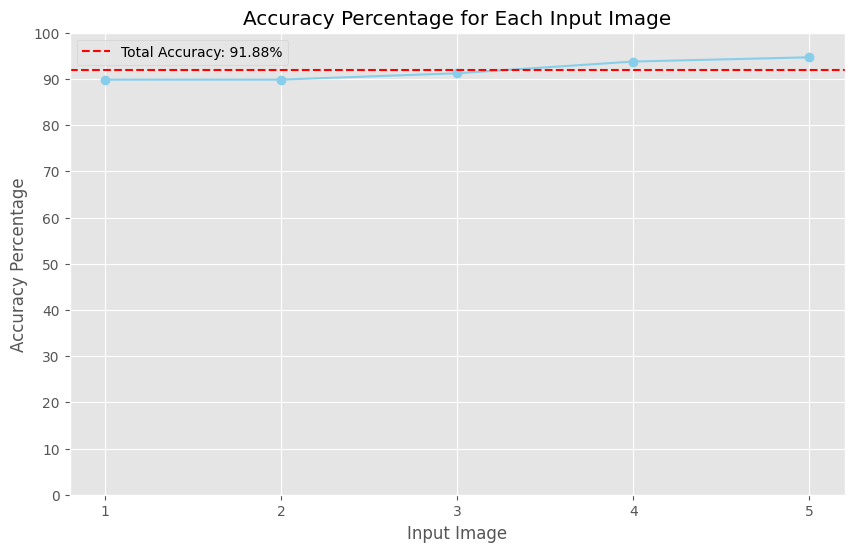

In [37]:
import matplotlib.pyplot as plt

similarity_scores = [
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9437440402332754, 0.9332969869959742, 0.9253229215714276, 0.9206422767283048, 0.9143679451871038, 0.8362684996122964],
    [0.9450994264887427, 0.9431201885786531, 0.9400545022379712, 0.9346222037080203, 0.9340654931824199, 0.9287955775353653],
    [0.9726985504510337, 0.9467401798211644, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]
]

accuracy_percentages = [(sum(scores) / len(scores)) * 100 for scores in similarity_scores]

total_accuracy_percentage = sum(accuracy_percentages) / len(accuracy_percentages)

x_values = range(1, len(accuracy_percentages) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x_values, accuracy_percentages, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Input Image')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage for Each Input Image')
plt.xticks(x_values)
plt.yticks(range(0, 101, 10))  # Set y-axis ticks from 0 to 100 in increments of 10
plt.axhline(y=total_accuracy_percentage, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy_percentage:.2f}%')
plt.legend()
plt.grid(True)
plt.show()


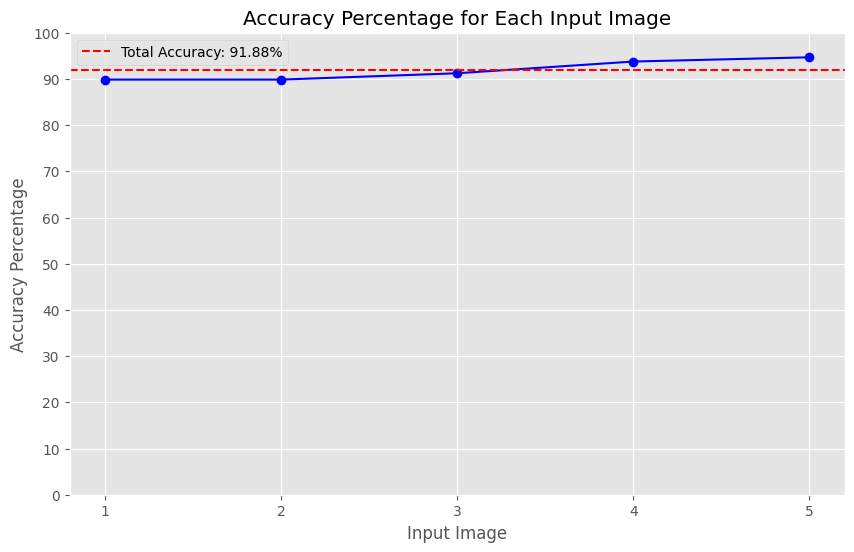

In [38]:
import matplotlib.pyplot as plt


similarity_scores = [
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9455690477712965, 0.9208131851230633, 0.9095907496582392, 0.893906776609137, 0.8663102645631924, 0.8549615234896648],
    [0.9437440402332754, 0.9332969869959742, 0.9253229215714276, 0.9206422767283048, 0.9143679451871038, 0.8362684996122964],
    [0.9450994264887427, 0.9431201885786531, 0.9400545022379712, 0.9346222037080203, 0.9340654931824199, 0.9287955775353653],
    [0.9726985504510337, 0.9467401798211644, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]
]


accuracy_percentages = [(sum(scores) / len(scores)) * 100 for scores in similarity_scores]


total_accuracy_percentage = sum(accuracy_percentages) / len(accuracy_percentages)


input_images = list(range(1, len(accuracy_percentages) + 1))


plt.figure(figsize=(10, 6))
plt.plot(input_images, accuracy_percentages, marker='o', color='blue', linestyle='-')
plt.axhline(y=total_accuracy_percentage, color='red', linestyle='--', label=f'Total Accuracy: {total_accuracy_percentage:.2f}%')
plt.xlabel('Input Image')
plt.ylabel('Accuracy Percentage')
plt.title('Accuracy Percentage for Each Input Image')
plt.xticks(input_images)
plt.yticks(range(0, 101, 10))
plt.grid(True)
plt.legend()
plt.show()


[0.9152470564531494, 0.9078768506675574, 0.907503323130422, 0.9051037334755389, 0.8991449369225306, 0.8988876218342876]


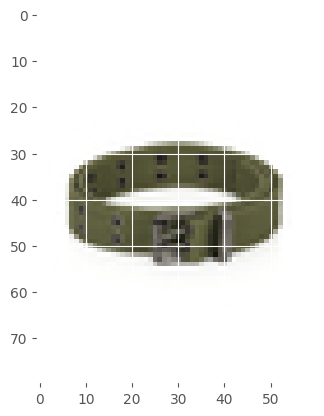

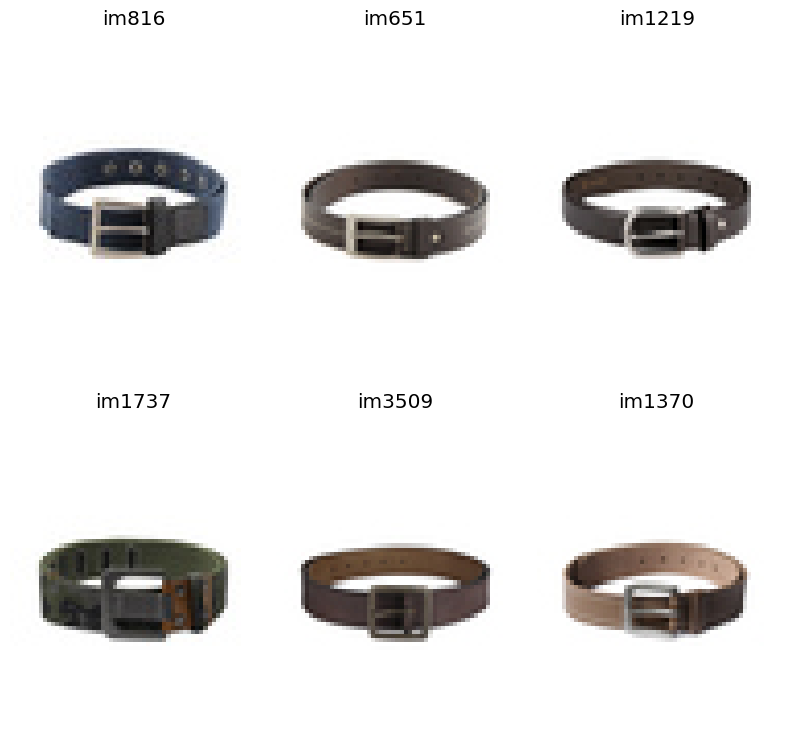

In [39]:
Rec_viz_image(1164)

[0.9152470564531494, 0.9078768506675574, 0.907503323130422, 0.9051037334755389, 0.8991449369225306, 0.8988876218342876]


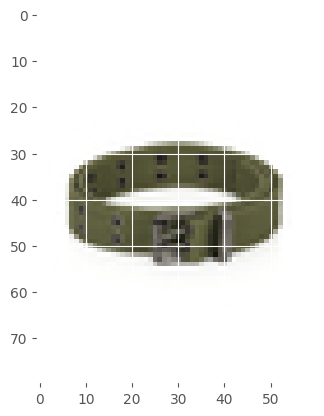

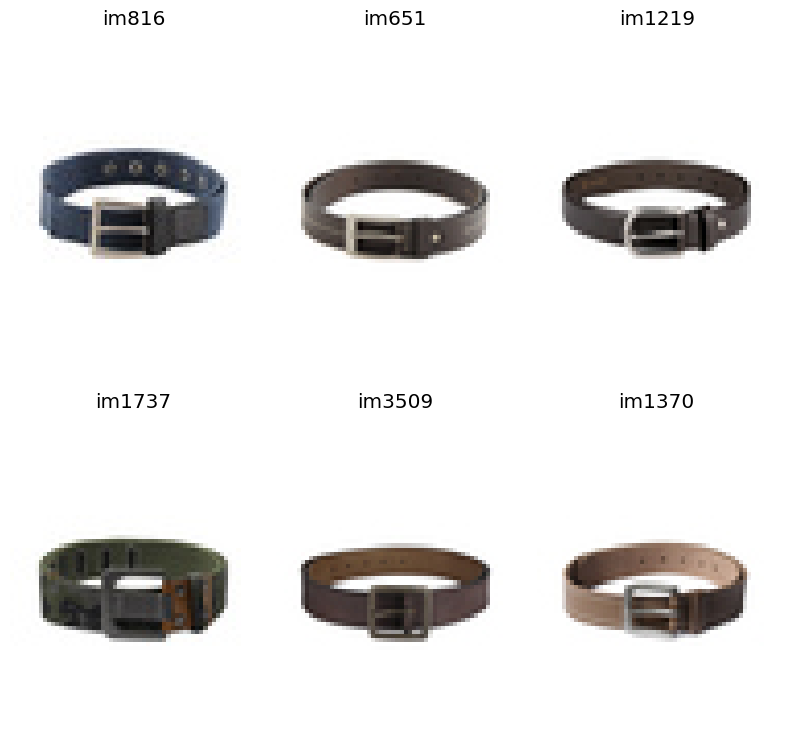

In [40]:
Rec_viz_image(1164)
